In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import os
import matplotlib.pyplot as plt
import matplotlib
import json
import ptitprince as pt
import sys
sys.path.append('..')

from src.visualization.plot import raincloud

font = {'family' : 'normal', 'weight': 'regular',
        'size'   : 25}
matplotlib.rc('font', **font)

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# Data cleaning

### load data and parse in order to retrieve "yes"/"no" answers

In [2]:
class DF(pd.DataFrame):
    def __init__(self, data):
        super().__init__(data=data)

    def avg_ind(self, groups):
        return self.groupby(groups, as_index=False).mean()
    
class Dataset:
    def __init__(self, gpt=None, human=None,
                 gpt_unclear=None, human_unclear=None):
        self.gpt = DF(gpt)
        self.gpt_unclear = DF(gpt_unclear)
        self.human_unclear = DF(human_unclear)
        self.human = DF(human)
        self.all = DF(pd.concat([gpt, human]))


def get_data(path, label=None, human=False):

    df = pd.read_csv(open(path, 'r', encoding='utf-8'))

    # exclude incomplete
    if human:
        df_124 = df.prolific_id.value_counts() == 124
        df = df[df.prolific_id.isin(df_124[df_124].index)]
        # remove controls 
        df = df[df['cond']!='control']
    # else:
        # df_124 = df.iter.value_counts() == 124
        # df = df[df.iter.isin(df_124[df_124].index)]
    if not label:
        df['exp'] = df['cond']
        df['a'] = df['answer']
    else:
        df['exp'] = label
        file = json.load(
            open('../data/external/greene/' + label + '.json', 'r', encoding='utf-8'))
        map_titles_id = {v['id']: v['title'] for v in file}
        df['title'] = df['item_id'].map(map_titles_id)
    
    # exclude the "why?"
    # df = df[df['q_id'] == 0]

    # df['a'] = df['a'].str.lower()

    # parse ("yes", A, or "yes,"")
    df['yes'] = df['a'].str.contains(pat=r'\b(yes)\b', regex=True, case=False) | df['a'].str.contains(
        pat=r'\b(\(A\))\b', regex=True, case=False) | df['a'].str.contains(pat=r'\b(yes,)\b', regex=True, case=False) | df['a'].str.lower().str.startswith(pat='yes,')
    df['no'] = df['a'].str.contains(pat=r'\b(no)\b', regex=True, case=False) | df['a'].str.contains(
        pat=r'\b(\(B\))\b', regex=True, case=False) | df['a'].str.contains(pat=r'\b(no,)\b', regex=True, case=False) | df['a'].str.lower().str.startswith(pat='no,')
    

    if '2' in path:
        df['source'] = 'dv2'
    elif '3' in path:
        df['source'] = 'dv3'
    else:
        pass

    df['unclear'] = df['yes'] == df['no']
    df['val'] = None
    df.loc[df['yes'] == 1, 'val'] = 'yes'
    df.loc[df['no'] == 1, 'val'] = 'no'
    df.loc[df['unclear'] == 1, 'val'] = 'unclear'
    df.loc[df['q_id']==1, 'val'] = 'na'
    df.loc[df['q_id']==1, 'yes'] = 'na'
    df.loc[df['q_id']==1, 'no'] = 'na'
    df.loc[df['q_id']==1, 'unclear'] = 'na'

    return df[df['unclear'] != 1], df


# ------------------------------------------------------------------------------------- #
# load gpt data
# ------------------------------------------------------------------------------------- #
foldernames_gpt = [
    '../data/raw/GPT3/greene/non_moral-003-last',
    '../data/raw/GPT3/greene/impersonal_moral-003-last',
    '../data/raw/GPT3/greene/personal_moral-003-last',
    '../data/raw/GPT3/greene/non_moral-002-last',
    '../data/raw/GPT3/greene/impersonal_moral-002-last',
    '../data/raw/GPT3/greene/personal_moral-002-last',
]
labels = ['non_moral', 'impersonal_moral', 'personal_moral', 'non_moral', 'impersonal_moral', 'personal_moral']

dfs = []
dfs_with_unclear = []

for foldername, l in zip(foldernames_gpt, labels):
    print(foldername)
    d, d_with_unclear = get_data(path=foldername+'/results.csv', label=l)
    dfs.append(d.copy())
    dfs_with_unclear.append(d_with_unclear.copy())


# ------------------------------------------------------------------------------------- #
# load human data
# ------------------------------------------------------------------------------------- #
foldernames_humans = [
    '../data/raw/HUMANS/greene_1.csv',
    '../data/raw/HUMANS/greene_2.csv'
]

dfs_ = []
dfs_with_unclear_ = []

for foldername, l in zip(foldernames_humans, labels):
    d, d_with_unclear = get_data(path=foldername, label=None, human=True)
    dfs_.append(d.copy())
    dfs_with_unclear_.append(d_with_unclear.copy())

ds = Dataset(
    gpt=pd.concat(dfs), gpt_unclear=pd.concat(dfs_with_unclear),
    human=pd.concat(dfs_), human_unclear=pd.concat(dfs_with_unclear_)
)

print('Unclear gpt proportion=' +
      str((ds.gpt_unclear['unclear'] == 1).sum()/len(ds.gpt_unclear[ds.gpt_unclear['q_id']==0])))
print('Unclear human proportion=' +
      str((ds.human_unclear['unclear'] == 1).sum()/len(ds.human_unclear[ds.human_unclear['q_id']==0])))

# ds.gpt[ds.gpt['title']=='sControl']

print('Complete gpt subjects=' + str(sum(ds.gpt_unclear.iter.value_counts()==(120))))
print('Complete human subjects=' + str(sum(ds.human_unclear.prolific_id.value_counts()==(120))))
# ds.human_unclear.to_csv('unclear_greene.csv')
# ds.human_unclear['len'] = ds.human_unclear.a.apply(lambda x: len(x) > 0)
# ds.human_unclear['len'] = ds.human_unclear.a.apply(lambda x: str(len(x) > 0) if isinstance(x, str) else 'type issue')
# df = ds.human_unclear.copy()
# pd.concat([
    # ds.human,
    # ds.gpt]).to_json('all.json', orient='records')


# df = pd.concat([
    # ds.human_unclear,
    # ds.gpt_unclear])

# df.to_csv('all.csv')

# load the manually corrected data (yes/no/unclear)
# df_final = pd.read_csv('H+GPT3/all_final.csv')
# df_final['yes'] = df_final.a0.str.contains('yes')
# df_final_dv3 = pd.read_csv('H+GPT3/dv3_all_final.csv')
# df_final_dv3['yes'] = df_final_dv3.a0.str.contains('yes')


    

../data/raw/GPT3/greene/non_moral-003-last
../data/raw/GPT3/greene/impersonal_moral-003-last
../data/raw/GPT3/greene/personal_moral-003-last
../data/raw/GPT3/greene/non_moral-002-last
../data/raw/GPT3/greene/impersonal_moral-002-last
../data/raw/GPT3/greene/personal_moral-002-last
Unclear gpt proportion=0.13555555555555557
Unclear human proportion=0.08333333333333333
Complete gpt subjects=0
Complete human subjects=31


# Define functions

In [3]:
def raincloud(x, y, markersize, df, order, width=1.1, bw=0.25, palette='Set2'):
    # f, ax = plt.subplots(figsize=(5*2.5, 5*2.5))

    means = df.groupby(x)[y].mean().reindex(order)
    sns.scatterplot(x=means.index, y=means, color='white', edgecolor='black', s=150/2, linewidth=1.5, zorder=4)


    ax = pt.half_violinplot(x=x, y=y, data=df, bw=bw, cut=0., linewidth=0, alpha=1, 
                            scale="area", width=width, inner=None, orient='v', zorder=1, palette=palette, order=order)

    ax = sns.stripplot(x=x, y=y, data=df,edgecolor="white",  linewidth=1, order=order,
                       size=markersize, orient='v', zorder=2, jitter=1, alpha=0.6, palette=palette)


    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, errorbar='se', linewidth=1, edgecolor='black', capsize=.1, zorder=3, bw=0, order=order)

def box_same_color(ax2):
    box_patches = [patch for patch in ax2.patches if type(
        patch) == matplotlib.patches.PathPatch]


    if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
        box_patches = ax2.artists
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax2.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # Set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same color as above
        for line in ax2.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers


# Fig 3

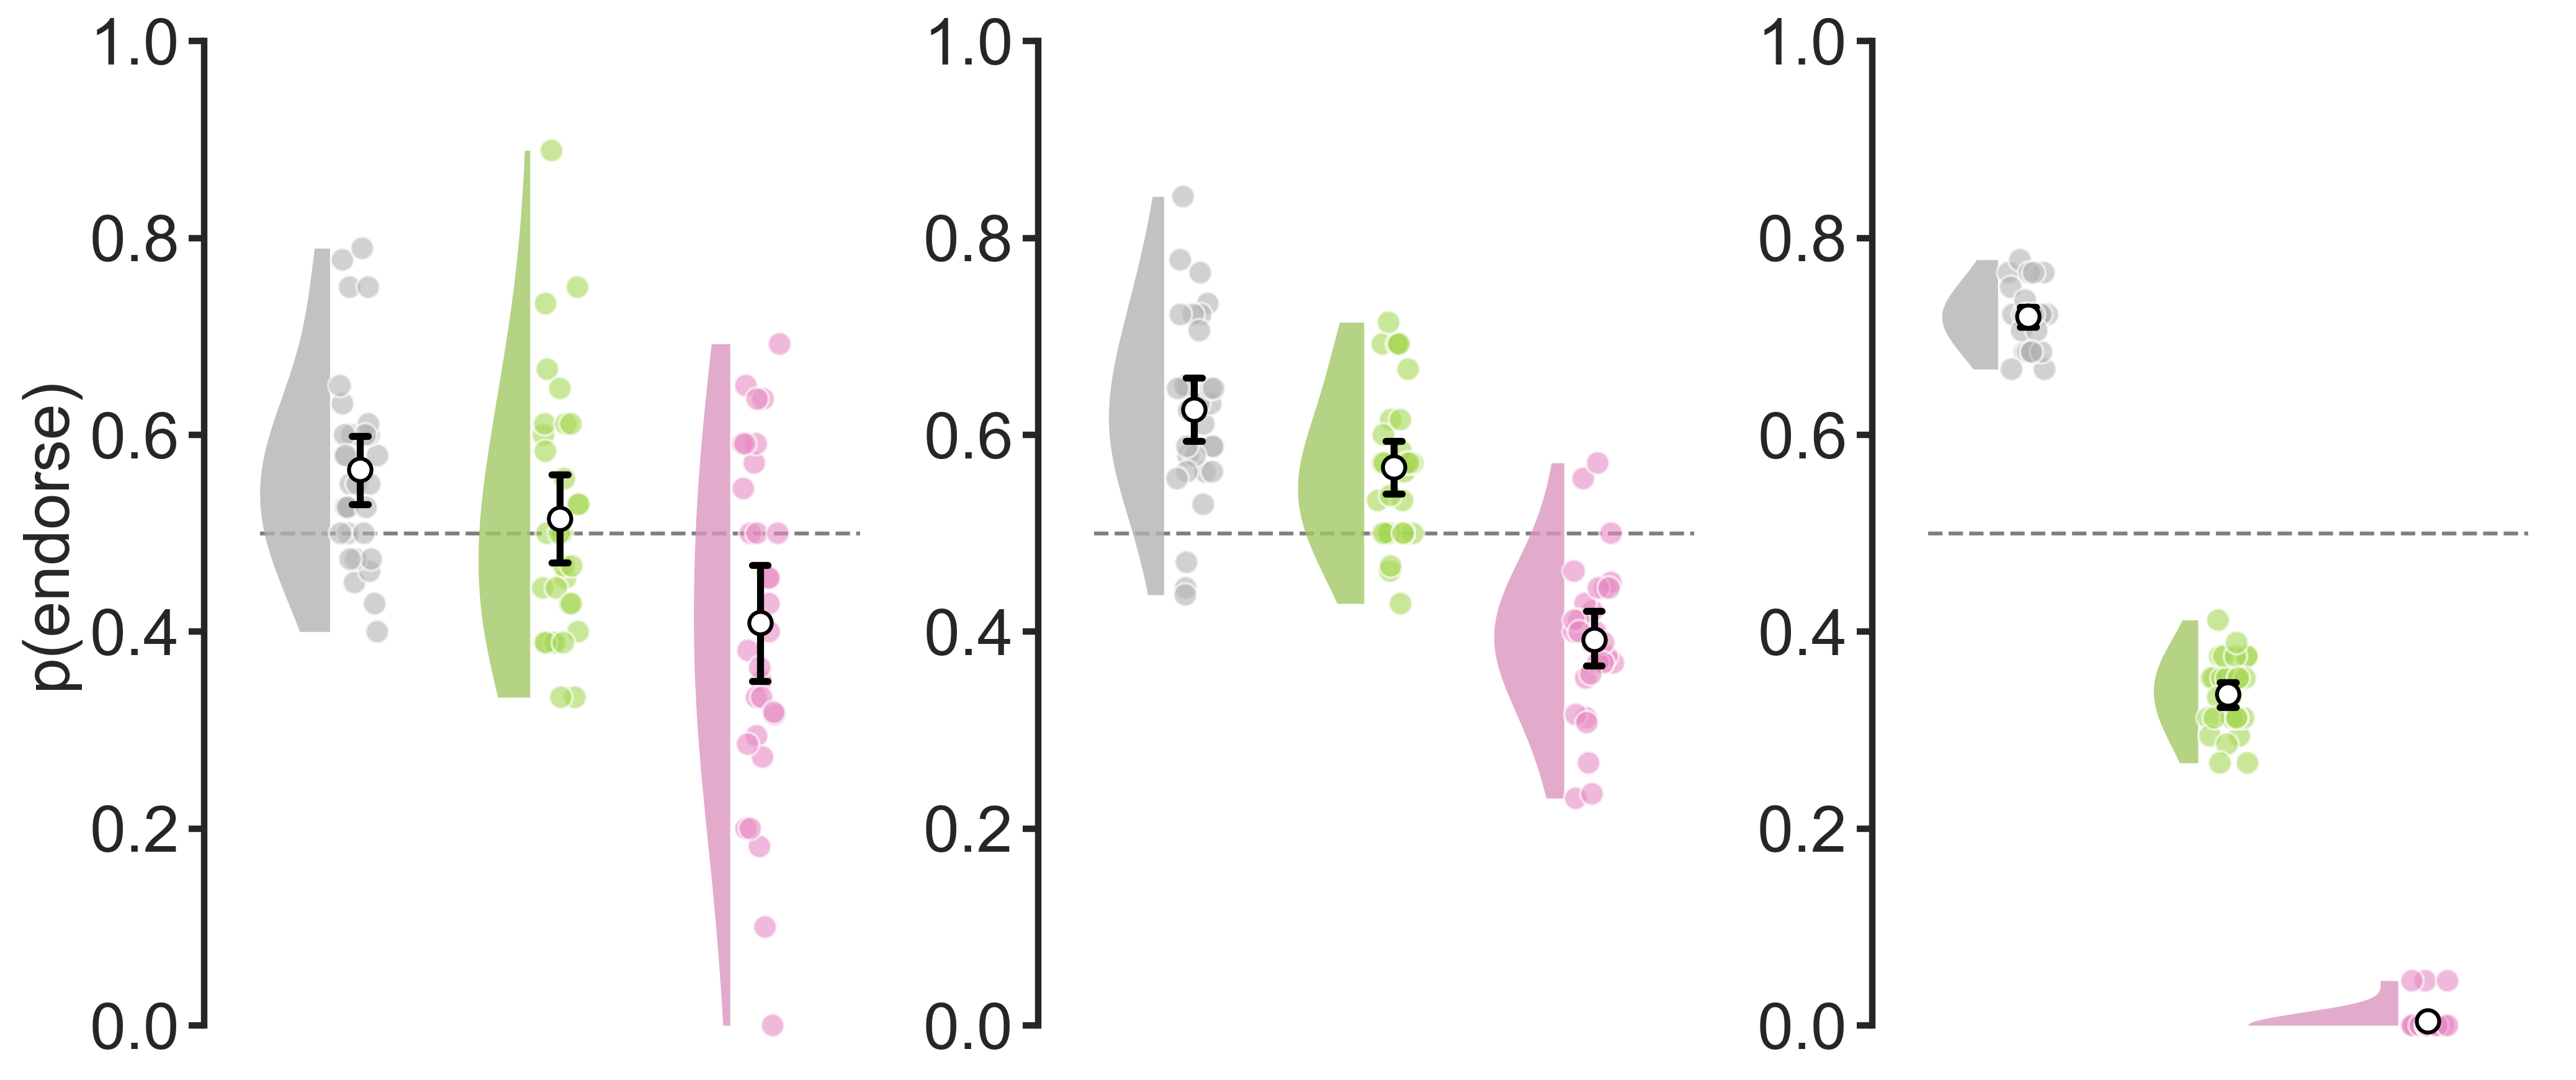

In [3]:
sns.set(
    rc={'figure.figsize':(14,6), "figure.dpi": 300, 'legend.fontsize': 20, 'axes.labelsize': 25,
      'xtick.labelsize': 25, 'ytick.labelsize': 25, 'font.family': 'sans-serif', 'axes.titlesize': 35,
      'font.sans-serif': 'Arial', 'text.usetex': False})
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

plt.rcParams['ytick.major.width'] = 2.5
order = ['non_moral', 'impersonal_moral', 'personal_moral']

ds.human = ds.human[ds.human.yes!='na']
ds.gpt = ds.gpt[ds.gpt.yes!='na']

dfh = ds.human.groupby(['prolific_id', 'cond'], as_index=False).yes.mean()

# rename col named exp as cond
ds.gpt = ds.gpt.rename(columns={'exp': 'cond'})
df2 = ds.gpt[ds.gpt.source=='dv2'].groupby(['iter', 'cond'], as_index=False).yes.mean()
df3 = ds.gpt[ds.gpt.source=='dv3'].groupby(['iter', 'cond'], as_index=False).yes.mean()

dfh['yes'] = dfh['yes'].astype(float)
df2['yes'] = df2['yes'].astype(float)
df3['yes'] = df3['yes'].astype(float)


plt.subplot(1, 3, 1)
# set color palette using Set2 C3 C4 C6
pal = sns.color_palette("Set2")
pal = [pal[7], pal[4], pal[3]]


raincloud(x='cond', y='yes', markersize=9, df=dfh, order=order, bw=0.8, palette=pal)# palette=sns.color_palette("Greys", 3))
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
plt.ylim(-.02, 1.02)
plt.ylabel('p(endorse)')
plt.xlabel('')
# xticks 45 degrees
plt.xticks(rotation=45)
# plt.xticks(labels=order, ticks=[0, 1, 2])
# plt.title('Humans')
plt.tick_params(bottom=False)
plt.gca().spines['left'].set_linewidth(2.5)
# remove xtick labels underscores
plt.xticks(labels=[l.replace('_', ' ') for l in order], ticks=[0, 1, 2])

plt.xticks([])
# plt.xlim(-.02, 1.02)

# 
plt.subplot(1, 3, 2)
# df = ds.human.avg_ind(['prolific_id', 'exp'])

raincloud(x='cond', y='yes', markersize=9, df=df2, order=order, bw=0.8, palette=pal)# palette=sns.color_palette("Greens", 3))
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
plt.xticks([])
plt.ylim(-.02, 1.02)
plt.ylabel('')
plt.xlabel('')
# plt.xticks(labels=order, ticks=[0, 1, 2])
# plt.title('GPT (DV2)')
# plt.xticks(labels=order, ticks=[0, 1, 2])
plt.tick_params(bottom=False)
#
plt.xticks(rotation=45)
sns.despine(offset=10, trim=True, bottom=True)
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks(labels=[l.replace('_', ' ') for l in order], ticks=[0, 1, 2])
plt.xticks([])

# df.groupby('exp').yes.mean()
plt.subplot(1, 3, 3)
# df = ds.human.avg_ind(['prolific_id', 'exp'])

raincloud(x='cond', y='yes', markersize=9, df=df3, order=order, width=1.5, bw=1, palette=pal)#palette=sns.color_palette("Reds", 3))
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
plt.ylim(-.02, 1.02)
plt.xlabel('')
plt.ylabel('')
# plt.title('GPT (DV3)')
plt.tick_params(bottom=False)
sns.despine(offset=10, trim=True, bottom=True)
plt.gca().spines['left'].set_linewidth(2.5)
plt.xticks([])


plt.xticks(rotation=45)
# plt.legend(['non moral', 'impersonal moral', 'personal moral'], loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4, fontsize=20)
plt.tight_layout()

# remove xtick labels


In [10]:
import pingouin as pg

pg.pairwise_tests(data=df3, dv='yes', within='cond', subject='iter', padjust='bonf')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,cond,impersonal_moral,non_moral,True,True,-42.764995,29.0,two-sided,9.425982e-28,2.827795e-27,bonf,2.183e+24,-11.482414
1,cond,impersonal_moral,personal_moral,True,True,49.282532,29.0,two-sided,1.626808e-29,4.880425e-29,bonf,1.095e+26,11.955902
2,cond,non_moral,personal_moral,True,True,112.807581,29.0,two-sided,6.919688e-40,2.075906e-39,bonf,1.12e+36,30.716782
